In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Mounted Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Read and preprocessing data**

In [3]:
data_path = "/content/drive/MyDrive/missingData/imbalance data/creditcard.csv"
df = pd.read_csv(data_path)

In [4]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Helper Function**

In [5]:
def calculate_metrics(model, X_test_scaled, Y_test):
    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)
    
    return acc, roc, prec, rec, f1

def train_and_get_metrics(X, Y):
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # define the model to use
    model = RandomForestClassifier(criterion='entropy', random_state=47)
    
    # Train the model
    model.fit(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    return acc, roc, prec, rec, f1

def evaluate_model_on_features(X, Y):    
    # Train the model, predict values and get metrics
    acc, roc, prec, rec, f1 = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    
    return display_df

**Feture Selection**

In [6]:
X = df.drop("Class",1)
y = df["Class"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [7]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.841793,0.999368,0.930556,0.683673,0.788235,30


**Colleration Matrix**

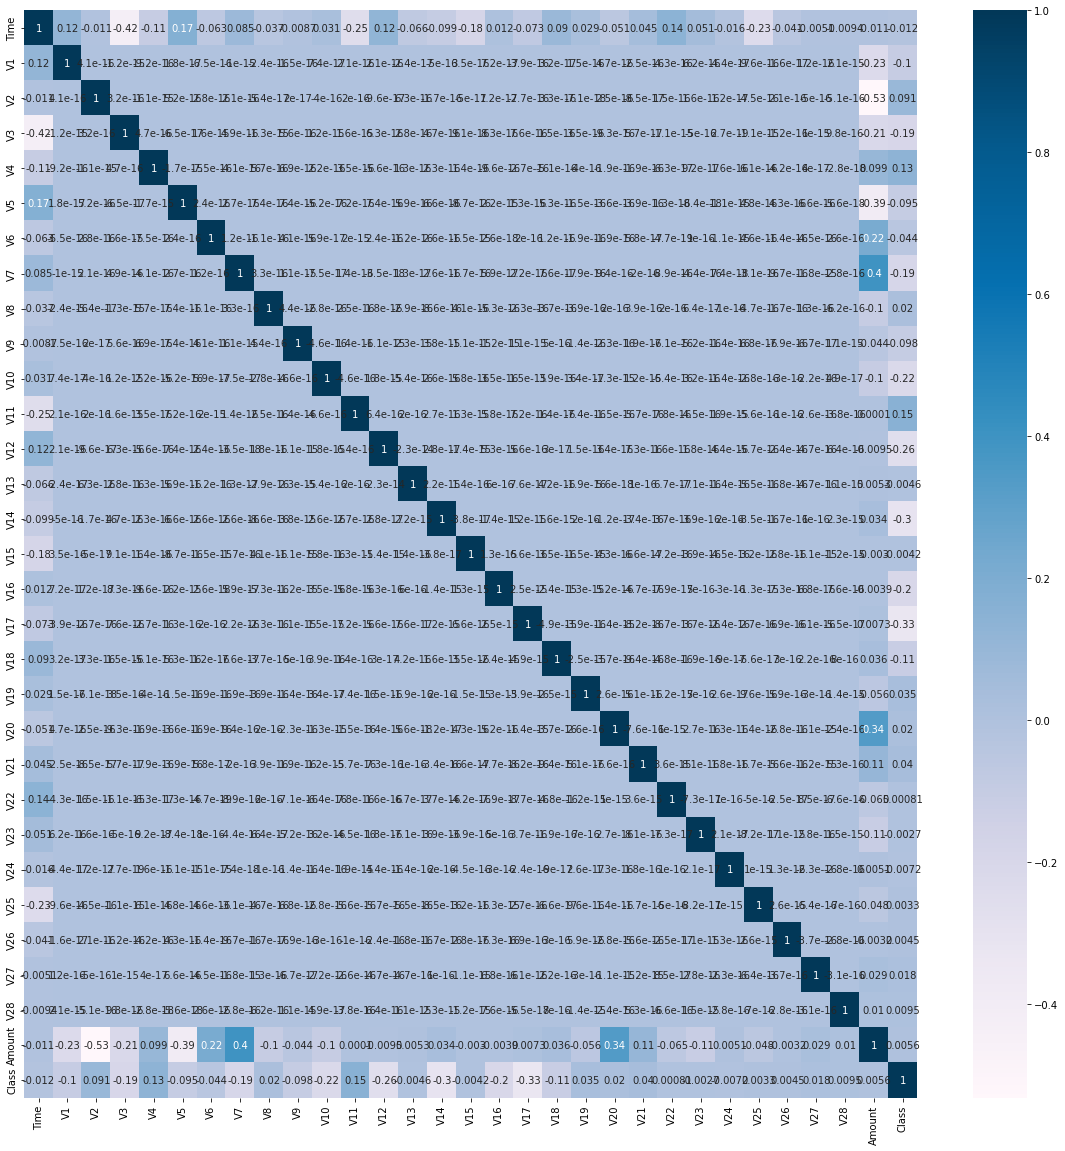

In [8]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = df.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

**Correlation with target feature**

In [9]:
# Get the absolute value of the correlation
cor_target = abs(cor["Class"])

# Select highly correlated features (thresold = 0.1)
relevant_features = cor_target[cor_target>0.1]

# Collect the names of the features
names = [index for index, value in relevant_features.iteritems()]

# Drop the target variable from the results
names.remove('Class')

# Display the results
print(names)


['V1', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']


In [10]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], y)
strong_features_eval_df.index = ['Strong features']

# Append to results and display
results = results.append(strong_features_eval_df)
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.841793,0.999368,0.930556,0.683673,0.788235,30
Strong features,0.857073,0.999368,0.897436,0.714286,0.795455,11


**Correlation with other feature**

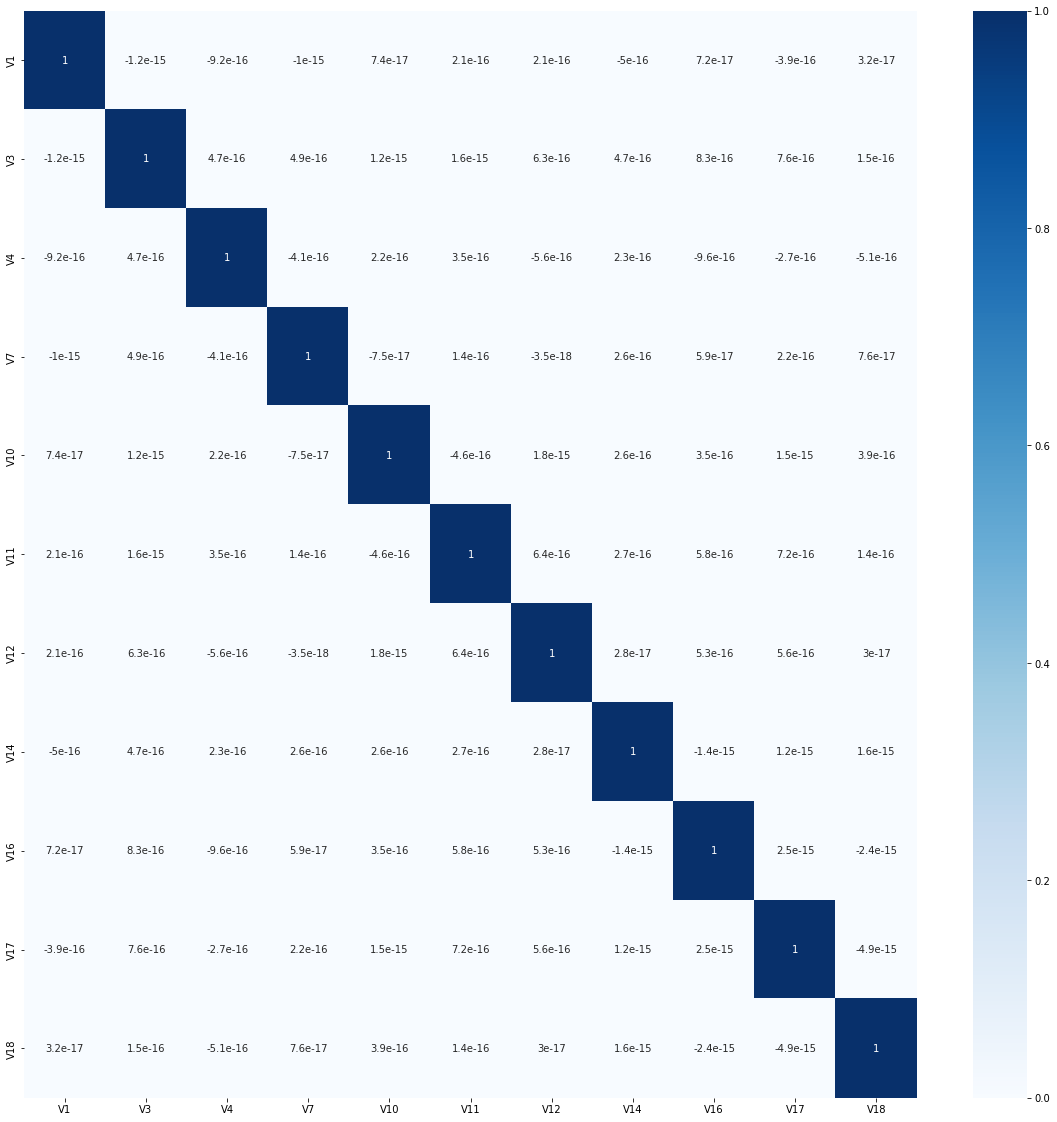

In [11]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

In [12]:
print("None envolved between feature high variance")

None envolved between feature high variance


**Univariate Selection**

In [13]:
#anova f-test
def univariate_selection():
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # User SelectKBest to select top 20 features based on f-test
    selector = SelectKBest(f_classif, k=10)
    
    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)
    
    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop("Class",1 ).columns, feature_idx):
        print("%s: %s" % (name, included))
    
    # Drop the target variable
    feature_names = df.drop("Class",1 ).columns[feature_idx]
    
    return feature_names

In [14]:
univariate_feature_names = univariate_selection()

Time: False
V1: False
V2: False
V3: True
V4: True
V5: False
V6: False
V7: True
V8: False
V9: False
V10: True
V11: True
V12: True
V13: False
V14: True
V15: False
V16: True
V17: True
V18: True
V19: False
V20: False
V21: False
V22: False
V23: False
V24: False
V25: False
V26: False
V27: False
V28: False
Amount: False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [15]:
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], y)
univariate_eval_df.index = ['F-test-10']

# Append to results and display
results = results.append(univariate_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.841793,0.999368,0.930556,0.683673,0.788235,30
Strong features,0.857073,0.999368,0.897436,0.714286,0.795455,11
F-test-10,0.851970,0.999350,0.896104,0.704082,0.788571,10


**Wrapper Method**

In [16]:
def run_rfe():
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the model
    model = RandomForestClassifier(criterion='entropy', random_state=47)
    
    # Wrap RFE around the model
    rfe = RFE(estimator=model,  n_features_to_select=8)
    
    # Fit RFE
    rfe = rfe.fit(X_train_scaled, Y_train)
    feature_names = df.drop("Class",1 ).columns[rfe.get_support()]
    
    return feature_names

In [ ]:
rfe_feature_names = run_rfe()
rfe_feature_names

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Index(['V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')

In [ ]:
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], y)
rfe_eval_df.index = ['RFE-8']

# Append to results and display
results = results.append(rfe_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.841793,0.999368,0.930556,0.683673,0.788235,30
Strong features,0.857073,0.999368,0.897436,0.714286,0.795455,11
F-test-10,0.851970,0.999350,0.896104,0.704082,0.788571,10
RFE-8,0.857073,0.999368,0.897436,0.714286,0.795455,8


**Embedded Method**

**Feature Importance**

In [ ]:
def feature_importances_from_tree_based_model_():
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state = 123)
    
    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,Y_train)
    
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()
    
    return model

In [ ]:
def select_features_from_model(model,threshold):
    
    model = SelectFromModel(model, prefit=True, threshold=threshold)
    feature_idx = model.get_support()
    feature_names = df.drop("Class",1 ).columns[feature_idx]
        
    return feature_names

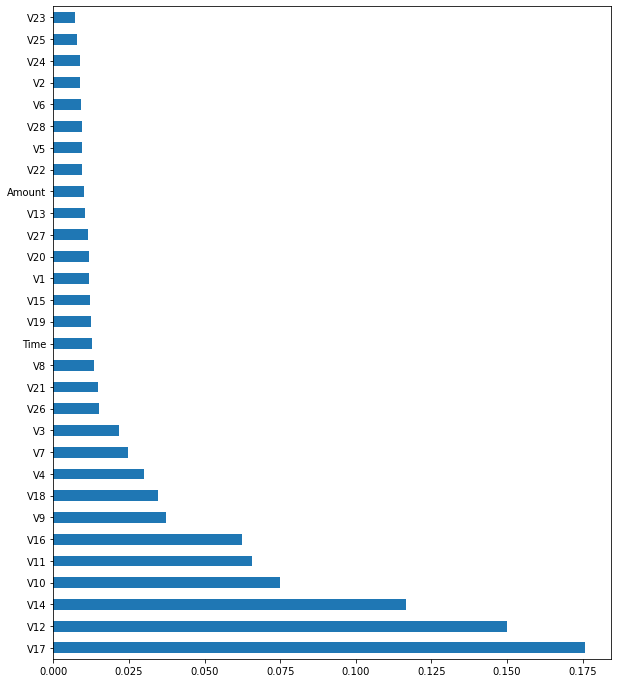

In [ ]:
model = feature_importances_from_tree_based_model_()

In [ ]:
feature_imp_feature_names = select_features_from_model(model,0.07)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = results.append(feat_imp_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.841793,0.999368,0.930556,0.683673,0.788235,30
Strong features,0.857073,0.999368,0.897436,0.714286,0.795455,11
F-test-10,0.851970,0.999350,0.896104,0.704082,0.788571,10
RFE-8,0.857073,0.999368,0.897436,0.714286,0.795455,8
Feature Importance,0.862210,0.999456,0.946667,0.724490,0.820809,4


**L1-regularization**

In [ ]:
def run_l1_regularization():
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2,stratify=y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select L1 regulated features from LinearSVC output 
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df.drop("Class",1 ).columns[(selection.get_support())]
    
    return feature_names

In [ ]:
l1reg_feature_names = run_l1_regularization()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


In [ ]:
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], y)
l1reg_eval_df.index = ['L1 Reg']

# Append to results and display
results = results.append(l1reg_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
Strong features,0.857073,0.999368,0.897436,0.714286,0.795455,11
F-test-10,0.851970,0.999350,0.896104,0.704082,0.788571,10
RFE-8,0.857073,0.999368,0.897436,0.714286,0.795455,8
Feature Importance,0.862210,0.999456,0.946667,0.724490,0.820809,4
L1 Reg,0.841793,0.999368,0.930556,0.683673,0.788235,30


**L1-regularization with Feature Importance**

In [ ]:
def run_l1_regularization_feature_importance():
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X[feature_imp_feature_names], y, test_size = 0.2,stratify=y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select L1 regulated features from LinearSVC output 
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df[feature_imp_feature_names].columns[(selection.get_support())]
    
    return feature_names

In [ ]:
l1reg_feature_names = run_l1_regularization_feature_importance()
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], y)
l1reg_eval_df.index = ['L1 Reg + FetureImportance']

# Append to results and display
results = results.append(l1reg_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
F-test-10,0.851970,0.999350,0.896104,0.704082,0.788571,10
RFE-8,0.857073,0.999368,0.897436,0.714286,0.795455,8
Feature Importance,0.862210,0.999456,0.946667,0.724490,0.820809,4
L1 Reg,0.841793,0.999368,0.930556,0.683673,0.788235,30
L1 Reg + FetureImportance,0.862210,0.999456,0.946667,0.724490,0.820809,4
